# Imports

In [1]:
import numpy as np
%cd ..
# I need this to access modules from the main folder. Do not move this comment up into the same line

import pandas as pd
from tqdm.notebook import tqdm
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from scipy import stats as st

from generate_dataframe import generate_sentences_and_meta_df_from_multiple_files
from load_saved_dataframe import load_saved_df
from numerals import *
from concordance import *
from helper_methods import try_apply, drop_na_with_count

C:\Users\karla\PycharmProjects\gender_linguistics_on_ParlaMint


# Set Parameters

In [2]:
# loading?
load_path = None # "C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv"

# generating?
number_of_files = None
random_seed = 1341995

# saving?
saving = True
save_name = "2023-03-06"

# Run

## Load / Generate

In [3]:
if load_path:
    df = load_saved_df(load_path)
else:
    df = generate_sentences_and_meta_df_from_multiple_files(number_of_files=number_of_files, random_seed=random_seed)
    if saving:
        df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv")

Generating Dataframe:   0%|          | 0/1795 [00:00<?, ?it/s]

In [4]:
n_sentences = df.shape[0]
print(f"total # of sentences: {n_sentences}")
df, dropped_due_to_original_nan = drop_na_with_count(df)
print(f"#sentences_dropped_due_to_original_nan: {dropped_due_to_original_nan}")

total # of sentences: 852883
#numbers_dropped_due_to_original_nan: 3965


## Numerals

In [5]:
func_arg_res = [(group_nums, 'sentence', 'sentence_grouped_nums'),
             (parse_num_groups, 'sentence_grouped_nums', 'sentence_parsed_num_groups'),
             (num_list, 'sentence_parsed_num_groups', 'NUMs')]
            # function, argument_column, result_column

drops_per_func = {}

for func, arg_col, res_col in func_arg_res:
    func_name = func.__name__
    print(f"Applying {func_name}")
    df[res_col] = df[arg_col].swifter.apply((lambda c: try_apply(func, c)))
    df, drops_per_func[func_name] = drop_na_with_count(df)

print("drop_reason".rjust(16)+" | #sentences_dropped"+"\n"+("="*37))
for func_name, drops in drops_per_func.items():
    print(func_name.rjust(16)+f" | {drops}")

Applying group_nums


Pandas Apply:   0%|          | 0/848918 [00:00<?, ?it/s]

Applying parse_num_groups


Pandas Apply:   0%|          | 0/838503 [00:00<?, ?it/s]

Applying num_list


Pandas Apply:   0%|          | 0/829307 [00:00<?, ?it/s]

     drop_reason | #sentences_dropped
      group_nums | 10415
parse_num_groups | 9196
        num_list | 0


In [6]:
df = df.explode('NUMs').reset_index(drop=True)
df['num_index'], placeholder = zip(*df['NUMs'])
(df['num_as_str'], df['num_value']) = zip(*placeholder)
n_numbers = df.shape[0]
print(f"#numbers: {n_numbers}")

#numbers: 1241728


In [7]:
df['is_float-like'], df['n_proper_digits'], df['n_zeroes'], df['n_decimals'] = zip(*df['num_as_str'].swifter.apply(lambda cell: try_apply(find_roundedness, cell)))

df, dropped_by_find_roundedness = drop_na_with_count(df)

print(f"#numbers_dropped_by_find_roundedness: {dropped_by_find_roundedness}")

Pandas Apply:   0%|          | 0/1241728 [00:00<?, ?it/s]

#numbers_dropped_by_find_roundedness: 7107


In [8]:
# TODO: look at nans (occur when num_value==0) before dropping them

df['absolute_uncertainty'], df['relative_uncertainty'] =zip(*df.swifter.apply(lambda row: try_apply(find_uncertainty, row), axis=1))

Pandas Apply:   0%|          | 0/1234621 [00:00<?, ?it/s]

In [10]:
for i in range(20):
    sorted_df = df.sort_values(by='relative_uncertainty', key=abs).reset_index()
    print(sorted_df['sentence'].iloc[i]['form'])

['£', '1,040,585,807', '—', 'that', 'is', 'the', 'value', 'of', 'Government', 'contracts', 'that', 'have', 'been', 'directly', 'awarded', 'without', 'competitive', 'tender', 'to', 'companies', 'that', 'have', 'links', 'to', 'the', 'Conservative', 'party', '’s', 'friends', 'or', 'donors', 'during', 'the', 'covid', 'crisis', '.']
['How', 'will', 'we', 'make', 'sure', 'that', 'we', 'do', 'not', 'suddenly', 'see', 'lots', 'of', 'taxed', 'persons', 'with', '£', '9,999,999.99', 'who', 'seem', 'to', 'know', 'each', 'other', 'quite', 'well', ',', 'or', 'at', 'least', 'seem', 'to', 'be', 'engaging', 'in', 'similar', 'activities', '?']
['In', 'the', 'time', 'it', 'took', 'the', 'Financial', 'Secretary', 'to', 'the', 'Treasury', 'to', 'pour', 'himself', 'a', 'glass', 'of', 'water', ',', 'the', 'House', 'authorised', 'the', 'Supply', 'and', 'Appropriation', '(', 'Main', 'Estimates', ')', '(', 'No.', '3', ')', 'Bill', ',', 'which', ',', 'among', 'other', 'things', ',', 'includes', '“', 'authorisati

In [ ]:
df['is_about_money'] = df.apply(lambda row: is_about_money(row, after_length=100), axis=1)

## Statistics

In [26]:
dfs = {'float_likes_only_df': df[df['is_float-like']],
       'int_likes_only_df': df[df['is_float-like'] == False]
       }

binary_independent_variables = {'is_upper_house': ('house', 'lower_house', 'upper_house'),
                    'is_chairperson': ('speaker_role', 'regular', 'chairperson'),
                    'is_mp': ('speaker_type', 'notMP', 'MP'),
                    'is_female': ('gender', 'male', 'female'),
                    'is_coalition': ('party_status', 'opposition', 'coalition')
                    #'is_about_money': ('counted_entity', 'other', 'money')
                    }
                    # column_name, variable_name, value1 (False), value2 (True)
dependent_variables = ['num_value', 'n_proper_digits', 'n_zeroes', 'relative_error']
max_dv_name_len = max((len(_dv) for _dv in dependent_variables))

SyntaxError: invalid syntax (Temp/ipykernel_20840/3120233163.py, line 9)

### Binary Independent Variables

In [ ]:
for biv in binary_independent_variables.keys():
    print("="*20,"\n",biv,"\n","-"*18)
    print(df[biv].value_counts())

In [ ]:
for df_name, _df in dfs.items():
    print(f"{'='*len(df_name)}\n{df_name}\n{'='*len(df_name)}")

    for biv in binary_independent_variables.keys():
        print(f"{'-'*len(biv)}\n{biv}\n{'-'*len(biv)}")

        # mannwhitneyu can only be calculated for two samples. sometimes, only one sample exists
        # (e.g. if all speakers are MPs --> _df[_df['is_mp'] == False] is empty)
        if len(_df[_df[biv] == True][dv]) != 0 and len(_df[_df[biv] == False][dv]) != 0:

            for dv in dependent_variables:
                mannwhitneyu_result = st.mannwhitneyu(_df[_df[biv] == True][dv], _df[_df[biv] == False][dv])
                print(f"{dv.ljust(max_dv_name_len)}: {mannwhitneyu_result}")

                pointbiserial_result = st.pointbiserialr(_df[biv], _df[dv])
                print(f"{dv.ljust(max_dv_name_len)}: {pointbiserial_result}")

                print("")
        else:
            print("binary independent variable only takes on one value --> 'unary' independent variable")

### Semi-Binary Independent Variable 'Party_status'

## Plots

### Histograms

In [ ]:
for df_name, _df in dfs.items():
    print(f"{'='*len(df_name)}\n{df_name}\n{'='*len(df_name)}")
    for dv in dependent_variables:

        plt.title("complete data")

        if dv == 'num_value':
            plt.xscale('log')
            bins = [10**i for i in range(15)]
        else:
            bins = range(15)

        plt.xlabel(dv)

        plt.hist(_df[dv], bins=bins)

        plt.show()

In [ ]:
for df_name, _df in dfs.items():
    print(f"{'='*len(df_name)}\n{df_name}\n{'='*len(df_name)}")

    for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():
        # TODO: handle party_status

        for biv_value, biv_value_bool in ((biv_false_value, False), (biv_true_value, True)):

            for dv in dependent_variables:

                plt.title(f"{biv_name}: {biv_value}")

                if dv == 'num_value':
                    plt.xscale('log')
                    bins = [5**i for i in range(30)]
                else:
                    bins = range(15)

                plt.xlabel(dv)

                plt.hist(_df[_df[biv_key] == biv_value_bool][dv], bins=bins)

                plt.show()

### Scatterplots

float_likes_only_df


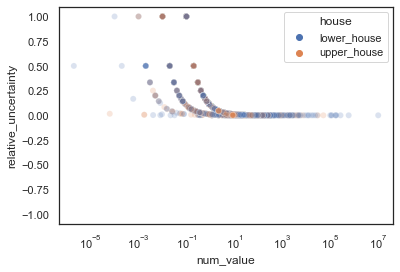

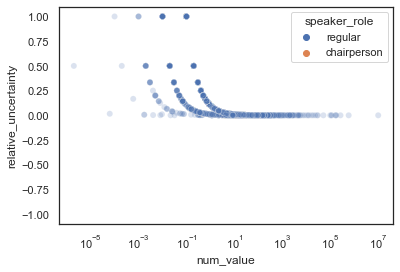

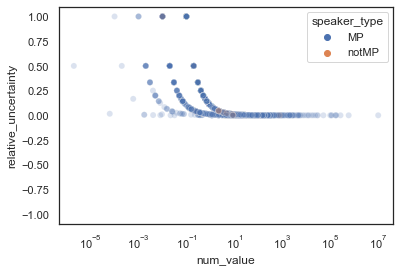

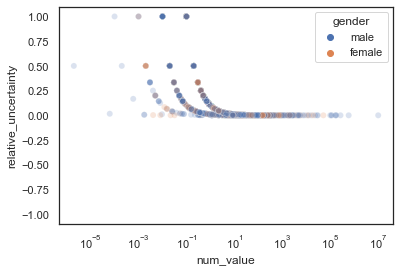

int_likes_only_df


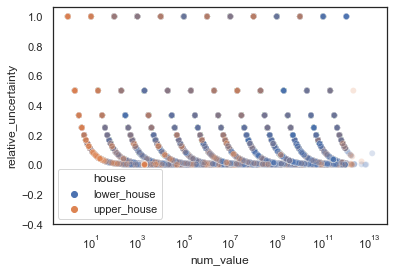

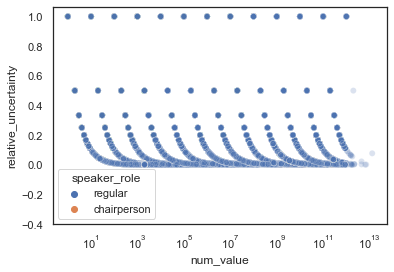

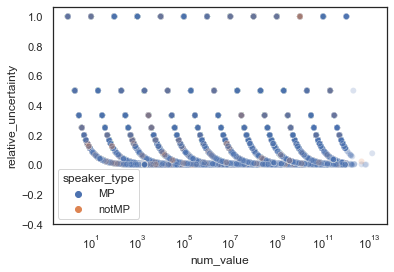

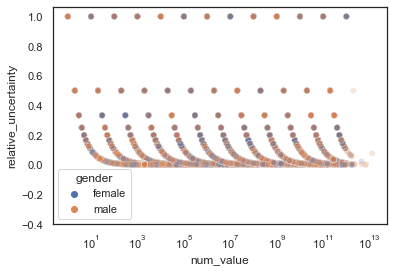

In [25]:
sns.set_theme(style="white") #TODO: remove this line (is already in imports)
for df_name in dfs.keys():
    print(df_name)
    for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():
        if biv_key == 'Party_status':
           _df = dfs[df_name][_df['Party_status'] != 'n/a']
        else:
            _df = dfs[df_name]
        # TODO: party_status handling: the above overwrites _df which is no bueno
        data = _df.copy()
        data[biv_name] = np.choose(data[biv_key], [biv_false_value, biv_true_value])
        x_axis = 'num_value'
        y_axis = 'relative_uncertainty'
        sns.scatterplot(x=x_axis, y=y_axis, hue=biv_name, data=data, alpha=0.2)
        plt.xscale('log')
        plt.savefig(f"C:/Users/karla/My Drive/Uni/LMU/Englisch/Zula/figures/scatterplots/{df_name}--{biv_name}--x-{x_axis}--y-{y_axis}.png", dpi=300)
        plt.show()

## Concordance

In [ ]:
df['num_ancestors'] = df.swifter.apply(concordance_ancestors_on_row, axis=1)

In [ ]:
df['num_ancestor_set'] = df['num_ancestors'].swifter.apply(lambda cell: try_apply(ancestry_set, cell))

In [ ]:
if saving:
    df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}+group+parsed+separated+exploded+roundedness+ancestors.csv")

In [ ]:
df['num_descendants'] = df.swifter.apply(concordance_descendants_on_row, axis=1)

In [ ]:
df['num_descendant_set'] = df['num_descendants'].swifter.apply(ancestry_set)

In [ ]:
if saving:
    df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}+group+parsed+separated+exploded+roundedness+ancestors+descendants.csv")

In [ ]:
value_count_num_descendant_set = df['num_descendant_set'].value_counts()
value_count_num_descendant_set

In [ ]:
value_count_num_ancestor_set = df['num_ancestor_set'].value_counts()
value_count_num_ancestor_set

In [ ]:
float_df = df[df['float-like']]

In [ ]:
int_df = df[df['float-like']==False]

In [ ]:
data = int_df.copy()
sns.scatterplot(x='num_value', y='n_zeroes', hue='Party_status', data=data)
plt.xscale('log')
plt.show()